**GeekHub 2018-2019 DL**

**Home work 13 Neural Networks**

Kaggle competion: https://www.kaggle.com/c/geekhub-ds-2019-challenge

Kaggle for colab

In [1]:
# import json

# !mkdir .kaggle
# token = {"username":"philkaua","key":"4d2727e8a90a45c00bd89a17e5ef6dbe"}
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)

In [0]:
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/content}
# !chmod 600 /root/.kaggle/kaggle.json

In [2]:
# Import numpy, keras submodules and some other modules

import cv2
import imageio
import scipy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
import random
import time
import kaggle

#from google.colab import drive
from glob import glob
from imgaug import augmenters as iaa
from keras import layers, initializers, optimizers, regularizers
from keras import datasets, models, callbacks, applications, utils

from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications import VGG16, VGG19, ResNet50, InceptionV3

from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

from shutil import copy2, move, rmtree

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


Load data from repository

In [0]:
#!kaggle competitions download -c geekhub-ds-2019-challenge
# !wget https://www.dropbox.com/s/ljcgvyjo95ogjs8/train_labels.csv
# !wget https://www.dropbox.com/s/bn4hedoc1q2tptc/train.zip
# !unzip -q "train.zip"
# !wget https://www.dropbox.com/s/n87ike3hk8ybkio/test.zip
# !unzip -q "test.zip"

File operations - load data

In [4]:
#Train and Test labels

# File operations
PATH_TO_DATA = os.path.abspath(os.curdir)
path_to_files_train = 'train/*'
path_to_files_test = 'test/*'

train_csv_file = pd.read_csv('train_labels.csv')['Category']

file_train = [file for file in sorted(glob(path_to_files_train))]
file_test = [file for file in sorted(glob(path_to_files_test))]

# Classes
class_names = np.unique(train_csv_file)
class_dict = {class_name:ind for ind, class_name in enumerate(class_names)}

# labels
train_labels = train_csv_file.map(class_dict).values

# Categories
categories = list(class_dict.keys())

print(f'Classes:{class_dict}\n')
print(f'Train labels:{train_labels.shape}\n')



for cls, label in class_dict.items():
    print(f'{cls} => {len(np.where(train_labels == label)[0])}')

Classes:{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Train labels:(3026,)

daisy => 536
dandelion => 743
rose => 569
sunflower => 483
tulip => 695


Load images

In [5]:
def load_image(path_categories):
    '''load images by cv2 
    '''
    # Load images by cv2
    images = []
    for files in path_categories:
        images_category = [cvtRGB(cv2.imread(file)) for file in files if (cv2.imread(file)) is not None]
        images.append(images_category)
    return images
  
def cvtRGB(img):
    '''convert cv2 BGR format to RGB'''
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
  
def load_image_out_category(path):
    images = []
    for file in path:
        images.append(cvtRGB(cv2.imread(file)))
    return images

In [6]:
%%time
img_width = 299
img_height = 299

# Image save 
submit_data = np.array(load_image_out_category(file_test))
all_data = np.array(load_image_out_category(file_train))

Wall time: 27.4 s


Resize images

In [7]:
%%time

submit_data_resized = []
for data in submit_data:
    submit_data_resized.append( cv2.resize(data, (img_width, img_height),interpolation = cv2.INTER_CUBIC) )
submit_data_resized = np.array(submit_data_resized)

all_data_resized = []
for data in all_data:
    all_data_resized.append( cv2.resize(data, (img_width, img_height),interpolation = cv2.INTER_CUBIC) )
all_data_resized = np.array(all_data_resized)

Wall time: 12.5 s


Sample

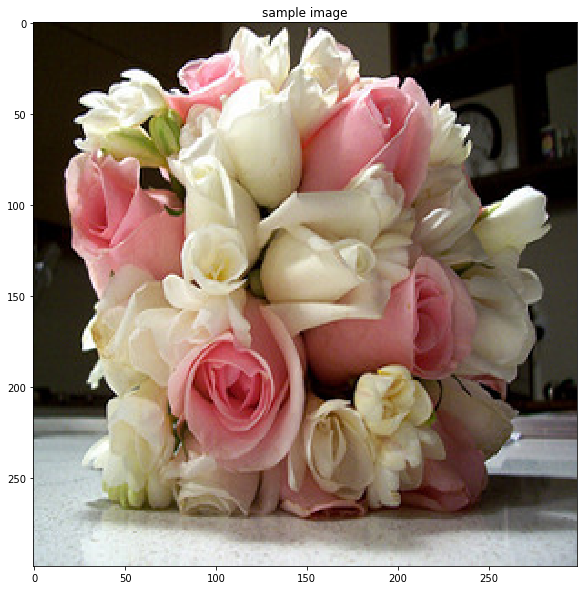

In [145]:
plt.figure(figsize=(10,10))
plt.title('sample image')
plt.grid(False)
plt.imshow(all_data_resized[0]);

Normalize image

In [246]:
def normalize_image(image, mean_image):
    '''std'''
    image = image / 255.
    mean_less = abs(image - mean_image)
    #std_image = np.std(image, axis = 0)  
    #mod_image = (mean_less/std_image) / np.max(mean_less/std_image)
    return mean_less
  
def mean_image(images):
    '''mean''' 
    #mean_image1 = np.mean(([frame for frame in train_data_resized_scaled]), axis=0)
    #sum(images) / images.shape[0]
    return np.mean(images, axis=0) / 255.

# Evaluating maen images
#mean_image_all = mean_image(all_data_resized) 
#mean_image_submit = mean_image(submit_data_resized)
mean_image_data = mean_image(np.append(all_data_resized, submit_data_resized, axis=0)) 

Sample normalization

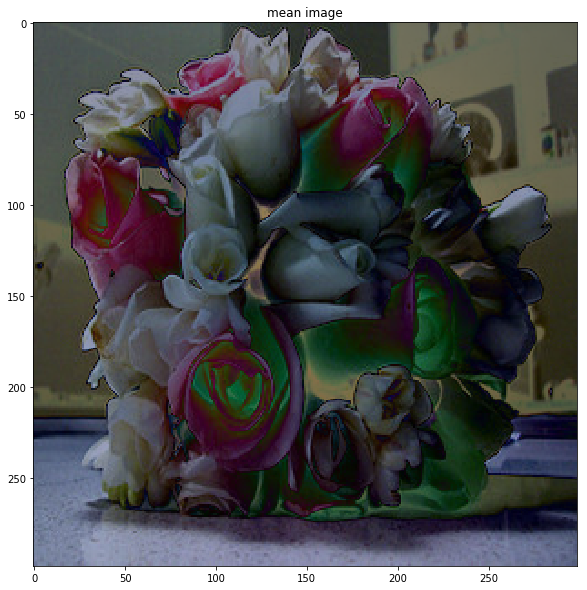

In [257]:
sample_norm = normalize_image(all_data_resized[0], mean_image_data)

plt.figure(figsize=(10,10))
plt.title('mean image')
plt.grid(False)
plt.imshow(sample_norm);

Path for files and creating folders

In [258]:
def save_image_path(path_files):
    return [*map(lambda x: 'mod_' + x, path_files)]

save_image_path_all = save_image_path(file_train)
save_image_path_submit = save_image_path(file_test)

# Create folders
if not os.path.isdir(save_image_path_submit[0][:-9]):
    os.makedirs(save_image_path_submit[0][:-9]) 

if not os.path.isdir(save_image_path_all[0][:-9]):
    os.makedirs(save_image_path_all[0][:-9])
#shutil.rmtree('data')

Normalize and save images

In [259]:
%%time
import warnings
warnings.filterwarnings('ignore')
import scipy

# all
for data, path in zip(all_data_resized, save_image_path_all):
    image = normalize_image(data, mean_image_data)
    scipy.misc.imsave(path,image)
    #image_load = PIL.Image.fromarray(image)
    #image_load.save(path)
    print('finish ->',path)


finish -> mod_train\0000.jpg
finish -> mod_train\0001.jpg
finish -> mod_train\0002.jpg
finish -> mod_train\0003.jpg
finish -> mod_train\0004.jpg
finish -> mod_train\0005.jpg
finish -> mod_train\0006.jpg
finish -> mod_train\0007.jpg
finish -> mod_train\0008.jpg
finish -> mod_train\0009.jpg
finish -> mod_train\0010.jpg
finish -> mod_train\0011.jpg
finish -> mod_train\0012.jpg
finish -> mod_train\0013.jpg
finish -> mod_train\0014.jpg
finish -> mod_train\0015.jpg
finish -> mod_train\0016.jpg
finish -> mod_train\0017.jpg
finish -> mod_train\0018.jpg
finish -> mod_train\0019.jpg
finish -> mod_train\0020.jpg
finish -> mod_train\0021.jpg
finish -> mod_train\0022.jpg
finish -> mod_train\0023.jpg
finish -> mod_train\0024.jpg
finish -> mod_train\0025.jpg
finish -> mod_train\0026.jpg
finish -> mod_train\0027.jpg
finish -> mod_train\0028.jpg
finish -> mod_train\0029.jpg
finish -> mod_train\0030.jpg
finish -> mod_train\0031.jpg
finish -> mod_train\0032.jpg
finish -> mod_train\0033.jpg
finish -> mod_

finish -> mod_train\0282.jpg
finish -> mod_train\0283.jpg
finish -> mod_train\0284.jpg
finish -> mod_train\0285.jpg
finish -> mod_train\0286.jpg
finish -> mod_train\0287.jpg
finish -> mod_train\0288.jpg
finish -> mod_train\0289.jpg
finish -> mod_train\0290.jpg
finish -> mod_train\0291.jpg
finish -> mod_train\0292.jpg
finish -> mod_train\0293.jpg
finish -> mod_train\0294.jpg
finish -> mod_train\0295.jpg
finish -> mod_train\0296.jpg
finish -> mod_train\0297.jpg
finish -> mod_train\0298.jpg
finish -> mod_train\0299.jpg
finish -> mod_train\0300.jpg
finish -> mod_train\0301.jpg
finish -> mod_train\0302.jpg
finish -> mod_train\0303.jpg
finish -> mod_train\0304.jpg
finish -> mod_train\0305.jpg
finish -> mod_train\0306.jpg
finish -> mod_train\0307.jpg
finish -> mod_train\0308.jpg
finish -> mod_train\0309.jpg
finish -> mod_train\0310.jpg
finish -> mod_train\0311.jpg
finish -> mod_train\0312.jpg
finish -> mod_train\0313.jpg
finish -> mod_train\0314.jpg
finish -> mod_train\0315.jpg
finish -> mod_

finish -> mod_train\0564.jpg
finish -> mod_train\0565.jpg
finish -> mod_train\0566.jpg
finish -> mod_train\0567.jpg
finish -> mod_train\0568.jpg
finish -> mod_train\0569.jpg
finish -> mod_train\0570.jpg
finish -> mod_train\0571.jpg
finish -> mod_train\0572.jpg
finish -> mod_train\0573.jpg
finish -> mod_train\0574.jpg
finish -> mod_train\0575.jpg
finish -> mod_train\0576.jpg
finish -> mod_train\0577.jpg
finish -> mod_train\0578.jpg
finish -> mod_train\0579.jpg
finish -> mod_train\0580.jpg
finish -> mod_train\0581.jpg
finish -> mod_train\0582.jpg
finish -> mod_train\0583.jpg
finish -> mod_train\0584.jpg
finish -> mod_train\0585.jpg
finish -> mod_train\0586.jpg
finish -> mod_train\0587.jpg
finish -> mod_train\0588.jpg
finish -> mod_train\0589.jpg
finish -> mod_train\0590.jpg
finish -> mod_train\0591.jpg
finish -> mod_train\0592.jpg
finish -> mod_train\0593.jpg
finish -> mod_train\0594.jpg
finish -> mod_train\0595.jpg
finish -> mod_train\0596.jpg
finish -> mod_train\0597.jpg
finish -> mod_

finish -> mod_train\0846.jpg
finish -> mod_train\0847.jpg
finish -> mod_train\0848.jpg
finish -> mod_train\0849.jpg
finish -> mod_train\0850.jpg
finish -> mod_train\0851.jpg
finish -> mod_train\0852.jpg
finish -> mod_train\0853.jpg
finish -> mod_train\0854.jpg
finish -> mod_train\0855.jpg
finish -> mod_train\0856.jpg
finish -> mod_train\0857.jpg
finish -> mod_train\0858.jpg
finish -> mod_train\0859.jpg
finish -> mod_train\0860.jpg
finish -> mod_train\0861.jpg
finish -> mod_train\0862.jpg
finish -> mod_train\0863.jpg
finish -> mod_train\0864.jpg
finish -> mod_train\0865.jpg
finish -> mod_train\0866.jpg
finish -> mod_train\0867.jpg
finish -> mod_train\0868.jpg
finish -> mod_train\0869.jpg
finish -> mod_train\0870.jpg
finish -> mod_train\0871.jpg
finish -> mod_train\0872.jpg
finish -> mod_train\0873.jpg
finish -> mod_train\0874.jpg
finish -> mod_train\0875.jpg
finish -> mod_train\0876.jpg
finish -> mod_train\0877.jpg
finish -> mod_train\0878.jpg
finish -> mod_train\0879.jpg
finish -> mod_

finish -> mod_train\1128.jpg
finish -> mod_train\1129.jpg
finish -> mod_train\1130.jpg
finish -> mod_train\1131.jpg
finish -> mod_train\1132.jpg
finish -> mod_train\1133.jpg
finish -> mod_train\1134.jpg
finish -> mod_train\1135.jpg
finish -> mod_train\1136.jpg
finish -> mod_train\1137.jpg
finish -> mod_train\1138.jpg
finish -> mod_train\1139.jpg
finish -> mod_train\1140.jpg
finish -> mod_train\1141.jpg
finish -> mod_train\1142.jpg
finish -> mod_train\1143.jpg
finish -> mod_train\1144.jpg
finish -> mod_train\1145.jpg
finish -> mod_train\1146.jpg
finish -> mod_train\1147.jpg
finish -> mod_train\1148.jpg
finish -> mod_train\1149.jpg
finish -> mod_train\1150.jpg
finish -> mod_train\1151.jpg
finish -> mod_train\1152.jpg
finish -> mod_train\1153.jpg
finish -> mod_train\1154.jpg
finish -> mod_train\1155.jpg
finish -> mod_train\1156.jpg
finish -> mod_train\1157.jpg
finish -> mod_train\1158.jpg
finish -> mod_train\1159.jpg
finish -> mod_train\1160.jpg
finish -> mod_train\1161.jpg
finish -> mod_

finish -> mod_train\1410.jpg
finish -> mod_train\1411.jpg
finish -> mod_train\1412.jpg
finish -> mod_train\1413.jpg
finish -> mod_train\1414.jpg
finish -> mod_train\1415.jpg
finish -> mod_train\1416.jpg
finish -> mod_train\1417.jpg
finish -> mod_train\1418.jpg
finish -> mod_train\1419.jpg
finish -> mod_train\1420.jpg
finish -> mod_train\1421.jpg
finish -> mod_train\1422.jpg
finish -> mod_train\1423.jpg
finish -> mod_train\1424.jpg
finish -> mod_train\1425.jpg
finish -> mod_train\1426.jpg
finish -> mod_train\1427.jpg
finish -> mod_train\1428.jpg
finish -> mod_train\1429.jpg
finish -> mod_train\1430.jpg
finish -> mod_train\1431.jpg
finish -> mod_train\1432.jpg
finish -> mod_train\1433.jpg
finish -> mod_train\1434.jpg
finish -> mod_train\1435.jpg
finish -> mod_train\1436.jpg
finish -> mod_train\1437.jpg
finish -> mod_train\1438.jpg
finish -> mod_train\1439.jpg
finish -> mod_train\1440.jpg
finish -> mod_train\1441.jpg
finish -> mod_train\1442.jpg
finish -> mod_train\1443.jpg
finish -> mod_

finish -> mod_train\1692.jpg
finish -> mod_train\1693.jpg
finish -> mod_train\1694.jpg
finish -> mod_train\1695.jpg
finish -> mod_train\1696.jpg
finish -> mod_train\1697.jpg
finish -> mod_train\1698.jpg
finish -> mod_train\1699.jpg
finish -> mod_train\1700.jpg
finish -> mod_train\1701.jpg
finish -> mod_train\1702.jpg
finish -> mod_train\1703.jpg
finish -> mod_train\1704.jpg
finish -> mod_train\1705.jpg
finish -> mod_train\1706.jpg
finish -> mod_train\1707.jpg
finish -> mod_train\1708.jpg
finish -> mod_train\1709.jpg
finish -> mod_train\1710.jpg
finish -> mod_train\1711.jpg
finish -> mod_train\1712.jpg
finish -> mod_train\1713.jpg
finish -> mod_train\1714.jpg
finish -> mod_train\1715.jpg
finish -> mod_train\1716.jpg
finish -> mod_train\1717.jpg
finish -> mod_train\1718.jpg
finish -> mod_train\1719.jpg
finish -> mod_train\1720.jpg
finish -> mod_train\1721.jpg
finish -> mod_train\1722.jpg
finish -> mod_train\1723.jpg
finish -> mod_train\1724.jpg
finish -> mod_train\1725.jpg
finish -> mod_

finish -> mod_train\1974.jpg
finish -> mod_train\1975.jpg
finish -> mod_train\1976.jpg
finish -> mod_train\1977.jpg
finish -> mod_train\1978.jpg
finish -> mod_train\1979.jpg
finish -> mod_train\1980.jpg
finish -> mod_train\1981.jpg
finish -> mod_train\1982.jpg
finish -> mod_train\1983.jpg
finish -> mod_train\1984.jpg
finish -> mod_train\1985.jpg
finish -> mod_train\1986.jpg
finish -> mod_train\1987.jpg
finish -> mod_train\1988.jpg
finish -> mod_train\1989.jpg
finish -> mod_train\1990.jpg
finish -> mod_train\1991.jpg
finish -> mod_train\1992.jpg
finish -> mod_train\1993.jpg
finish -> mod_train\1994.jpg
finish -> mod_train\1995.jpg
finish -> mod_train\1996.jpg
finish -> mod_train\1997.jpg
finish -> mod_train\1998.jpg
finish -> mod_train\1999.jpg
finish -> mod_train\2000.jpg
finish -> mod_train\2001.jpg
finish -> mod_train\2002.jpg
finish -> mod_train\2003.jpg
finish -> mod_train\2004.jpg
finish -> mod_train\2005.jpg
finish -> mod_train\2006.jpg
finish -> mod_train\2007.jpg
finish -> mod_

finish -> mod_train\2256.jpg
finish -> mod_train\2257.jpg
finish -> mod_train\2258.jpg
finish -> mod_train\2259.jpg
finish -> mod_train\2260.jpg
finish -> mod_train\2261.jpg
finish -> mod_train\2262.jpg
finish -> mod_train\2263.jpg
finish -> mod_train\2264.jpg
finish -> mod_train\2265.jpg
finish -> mod_train\2266.jpg
finish -> mod_train\2267.jpg
finish -> mod_train\2268.jpg
finish -> mod_train\2269.jpg
finish -> mod_train\2270.jpg
finish -> mod_train\2271.jpg
finish -> mod_train\2272.jpg
finish -> mod_train\2273.jpg
finish -> mod_train\2274.jpg
finish -> mod_train\2275.jpg
finish -> mod_train\2276.jpg
finish -> mod_train\2277.jpg
finish -> mod_train\2278.jpg
finish -> mod_train\2279.jpg
finish -> mod_train\2280.jpg
finish -> mod_train\2281.jpg
finish -> mod_train\2282.jpg
finish -> mod_train\2283.jpg
finish -> mod_train\2284.jpg
finish -> mod_train\2285.jpg
finish -> mod_train\2286.jpg
finish -> mod_train\2287.jpg
finish -> mod_train\2288.jpg
finish -> mod_train\2289.jpg
finish -> mod_

finish -> mod_train\2538.jpg
finish -> mod_train\2539.jpg
finish -> mod_train\2540.jpg
finish -> mod_train\2541.jpg
finish -> mod_train\2542.jpg
finish -> mod_train\2543.jpg
finish -> mod_train\2544.jpg
finish -> mod_train\2545.jpg
finish -> mod_train\2546.jpg
finish -> mod_train\2547.jpg
finish -> mod_train\2548.jpg
finish -> mod_train\2549.jpg
finish -> mod_train\2550.jpg
finish -> mod_train\2551.jpg
finish -> mod_train\2552.jpg
finish -> mod_train\2553.jpg
finish -> mod_train\2554.jpg
finish -> mod_train\2555.jpg
finish -> mod_train\2556.jpg
finish -> mod_train\2557.jpg
finish -> mod_train\2558.jpg
finish -> mod_train\2559.jpg
finish -> mod_train\2560.jpg
finish -> mod_train\2561.jpg
finish -> mod_train\2562.jpg
finish -> mod_train\2563.jpg
finish -> mod_train\2564.jpg
finish -> mod_train\2565.jpg
finish -> mod_train\2566.jpg
finish -> mod_train\2567.jpg
finish -> mod_train\2568.jpg
finish -> mod_train\2569.jpg
finish -> mod_train\2570.jpg
finish -> mod_train\2571.jpg
finish -> mod_

finish -> mod_train\2820.jpg
finish -> mod_train\2821.jpg
finish -> mod_train\2822.jpg
finish -> mod_train\2823.jpg
finish -> mod_train\2824.jpg
finish -> mod_train\2825.jpg
finish -> mod_train\2826.jpg
finish -> mod_train\2827.jpg
finish -> mod_train\2828.jpg
finish -> mod_train\2829.jpg
finish -> mod_train\2830.jpg
finish -> mod_train\2831.jpg
finish -> mod_train\2832.jpg
finish -> mod_train\2833.jpg
finish -> mod_train\2834.jpg
finish -> mod_train\2835.jpg
finish -> mod_train\2836.jpg
finish -> mod_train\2837.jpg
finish -> mod_train\2838.jpg
finish -> mod_train\2839.jpg
finish -> mod_train\2840.jpg
finish -> mod_train\2841.jpg
finish -> mod_train\2842.jpg
finish -> mod_train\2843.jpg
finish -> mod_train\2844.jpg
finish -> mod_train\2845.jpg
finish -> mod_train\2846.jpg
finish -> mod_train\2847.jpg
finish -> mod_train\2848.jpg
finish -> mod_train\2849.jpg
finish -> mod_train\2850.jpg
finish -> mod_train\2851.jpg
finish -> mod_train\2852.jpg
finish -> mod_train\2853.jpg
finish -> mod_

In [261]:
%%time
#sumbmiss
for data, path in zip(submit_data_resized, save_image_path_submit):
    image = normalize_image(data, mean_image_data)
    scipy.misc.imsave(path,image)
    print('finish ->',path)

finish -> mod_test\3026.jpg
finish -> mod_test\3027.jpg
finish -> mod_test\3028.jpg
finish -> mod_test\3029.jpg
finish -> mod_test\3030.jpg
finish -> mod_test\3031.jpg
finish -> mod_test\3032.jpg
finish -> mod_test\3033.jpg
finish -> mod_test\3034.jpg
finish -> mod_test\3035.jpg
finish -> mod_test\3036.jpg
finish -> mod_test\3037.jpg
finish -> mod_test\3038.jpg
finish -> mod_test\3039.jpg
finish -> mod_test\3040.jpg
finish -> mod_test\3041.jpg
finish -> mod_test\3042.jpg
finish -> mod_test\3043.jpg
finish -> mod_test\3044.jpg
finish -> mod_test\3045.jpg
finish -> mod_test\3046.jpg
finish -> mod_test\3047.jpg
finish -> mod_test\3048.jpg
finish -> mod_test\3049.jpg
finish -> mod_test\3050.jpg
finish -> mod_test\3051.jpg
finish -> mod_test\3052.jpg
finish -> mod_test\3053.jpg
finish -> mod_test\3054.jpg
finish -> mod_test\3055.jpg
finish -> mod_test\3056.jpg
finish -> mod_test\3057.jpg
finish -> mod_test\3058.jpg
finish -> mod_test\3059.jpg
finish -> mod_test\3060.jpg
finish -> mod_test\3

finish -> mod_test\3318.jpg
finish -> mod_test\3319.jpg
finish -> mod_test\3320.jpg
finish -> mod_test\3321.jpg
finish -> mod_test\3322.jpg
finish -> mod_test\3323.jpg
finish -> mod_test\3324.jpg
finish -> mod_test\3325.jpg
finish -> mod_test\3326.jpg
finish -> mod_test\3327.jpg
finish -> mod_test\3328.jpg
finish -> mod_test\3329.jpg
finish -> mod_test\3330.jpg
finish -> mod_test\3331.jpg
finish -> mod_test\3332.jpg
finish -> mod_test\3333.jpg
finish -> mod_test\3334.jpg
finish -> mod_test\3335.jpg
finish -> mod_test\3336.jpg
finish -> mod_test\3337.jpg
finish -> mod_test\3338.jpg
finish -> mod_test\3339.jpg
finish -> mod_test\3340.jpg
finish -> mod_test\3341.jpg
finish -> mod_test\3342.jpg
finish -> mod_test\3343.jpg
finish -> mod_test\3344.jpg
finish -> mod_test\3345.jpg
finish -> mod_test\3346.jpg
finish -> mod_test\3347.jpg
finish -> mod_test\3348.jpg
finish -> mod_test\3349.jpg
finish -> mod_test\3350.jpg
finish -> mod_test\3351.jpg
finish -> mod_test\3352.jpg
finish -> mod_test\3

finish -> mod_test\3610.jpg
finish -> mod_test\3611.jpg
finish -> mod_test\3612.jpg
finish -> mod_test\3613.jpg
finish -> mod_test\3614.jpg
finish -> mod_test\3615.jpg
finish -> mod_test\3616.jpg
finish -> mod_test\3617.jpg
finish -> mod_test\3618.jpg
finish -> mod_test\3619.jpg
finish -> mod_test\3620.jpg
finish -> mod_test\3621.jpg
finish -> mod_test\3622.jpg
finish -> mod_test\3623.jpg
finish -> mod_test\3624.jpg
finish -> mod_test\3625.jpg
finish -> mod_test\3626.jpg
finish -> mod_test\3627.jpg
finish -> mod_test\3628.jpg
finish -> mod_test\3629.jpg
finish -> mod_test\3630.jpg
finish -> mod_test\3631.jpg
finish -> mod_test\3632.jpg
finish -> mod_test\3633.jpg
finish -> mod_test\3634.jpg
finish -> mod_test\3635.jpg
finish -> mod_test\3636.jpg
finish -> mod_test\3637.jpg
finish -> mod_test\3638.jpg
finish -> mod_test\3639.jpg
finish -> mod_test\3640.jpg
finish -> mod_test\3641.jpg
finish -> mod_test\3642.jpg
finish -> mod_test\3643.jpg
finish -> mod_test\3644.jpg
finish -> mod_test\3

finish -> mod_test\3902.jpg
finish -> mod_test\3903.jpg
finish -> mod_test\3904.jpg
finish -> mod_test\3905.jpg
finish -> mod_test\3906.jpg
finish -> mod_test\3907.jpg
finish -> mod_test\3908.jpg
finish -> mod_test\3909.jpg
finish -> mod_test\3910.jpg
finish -> mod_test\3911.jpg
finish -> mod_test\3912.jpg
finish -> mod_test\3913.jpg
finish -> mod_test\3914.jpg
finish -> mod_test\3915.jpg
finish -> mod_test\3916.jpg
finish -> mod_test\3917.jpg
finish -> mod_test\3918.jpg
finish -> mod_test\3919.jpg
finish -> mod_test\3920.jpg
finish -> mod_test\3921.jpg
finish -> mod_test\3922.jpg
finish -> mod_test\3923.jpg
finish -> mod_test\3924.jpg
finish -> mod_test\3925.jpg
finish -> mod_test\3926.jpg
finish -> mod_test\3927.jpg
finish -> mod_test\3928.jpg
finish -> mod_test\3929.jpg
finish -> mod_test\3930.jpg
finish -> mod_test\3931.jpg
finish -> mod_test\3932.jpg
finish -> mod_test\3933.jpg
finish -> mod_test\3934.jpg
finish -> mod_test\3935.jpg
finish -> mod_test\3936.jpg
finish -> mod_test\3

finish -> mod_test\4194.jpg
finish -> mod_test\4195.jpg
finish -> mod_test\4196.jpg
finish -> mod_test\4197.jpg
finish -> mod_test\4198.jpg
finish -> mod_test\4199.jpg
finish -> mod_test\4200.jpg
finish -> mod_test\4201.jpg
finish -> mod_test\4202.jpg
finish -> mod_test\4203.jpg
finish -> mod_test\4204.jpg
finish -> mod_test\4205.jpg
finish -> mod_test\4206.jpg
finish -> mod_test\4207.jpg
finish -> mod_test\4208.jpg
finish -> mod_test\4209.jpg
finish -> mod_test\4210.jpg
finish -> mod_test\4211.jpg
finish -> mod_test\4212.jpg
finish -> mod_test\4213.jpg
finish -> mod_test\4214.jpg
finish -> mod_test\4215.jpg
finish -> mod_test\4216.jpg
finish -> mod_test\4217.jpg
finish -> mod_test\4218.jpg
finish -> mod_test\4219.jpg
finish -> mod_test\4220.jpg
finish -> mod_test\4221.jpg
finish -> mod_test\4222.jpg
finish -> mod_test\4223.jpg
finish -> mod_test\4224.jpg
finish -> mod_test\4225.jpg
finish -> mod_test\4226.jpg
finish -> mod_test\4227.jpg
finish -> mod_test\4228.jpg
finish -> mod_test\4